In [29]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D
from tensorflow.keras.layers import AveragePooling2D, Dense, Input, Lambda, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [30]:
# Goal: 60% train, 20% validate, 20% test -> 80% train+validate, 20% test

folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [31]:
# Read in files from folders, store as np arrays of images (X_train) and clinsig labels (y_train)
# clinsig TRUE = 1, FALSE = 0
X = []
y = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))    
        if adc_t2 == 'adc':
            if label == 'TRUE':
                X += 3 * [array]
                y += 3 * [1]
            else:
                X.append(array)
                y.append(0)

# Random over-sampling to remedy imbalanced dataset
print('Original: indolent={}, clinsig={}'.format(Counter(y)[0], Counter(y)[1]))

Original: indolent=196, clinsig=180


In [38]:
X, y = shuffle(X, y)

# Now split this into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1).split(X_train, y_train))

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=282, nval=94


In [33]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
# conv_base.summary()

In [34]:
chanDim = 3

model = tf.keras.Sequential()
model.add(conv_base)

model.add(Conv2D(32, (3, 3), padding="same")) # kernel_initializer=init ? 
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

for i in range(9):
    model.add(Conv2D(32, (3, 3), padding="same")) 
    model.add(BatchNormalization(axis=chanDim))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    
model.add(AveragePooling2D(pool_size=(3, 3), padding="same"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #Sigmoid function at the end because we have just two classes

# model.summary()

In [35]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

# binary_crossentropy loss because its a binary classification
# model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), metrics=['acc'])
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=3e-4), metrics=['acc'])

Number of trainable weights before freezing the conv base: 292
Number of trainable weights after freezing the conv base: 80


In [39]:
batch_size = 64

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],

In [47]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_val_cv = X_train[val_idx]
    y_val_cv= y_train[val_idx]
    
    name_weights = "models/model_adc_kfold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    train_generator = train_datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val_cv, y_val_cv, batch_size=batch_size)
    history = model.fit(
                    train_generator,
                    steps_per_epoch=len(X_train_cv)//batch_size,
                    epochs=70,
                    shuffle=True,
                    verbose=1,
                    validation_data=val_generator,
#                     validation_steps=len(X_val_cv)//batch_size,
                    callbacks = callbacks)
    
    print(model.evaluate(X_val_cv, y_val_cv))
    

# history = model.fit(train_generator,
#                     steps_per_epoch=ntrain//batch_size,
#                     epochs=170,
#                     validation_data=val_generator,
#                     validation_steps=nval//batch_size)


Fold  0
Epoch 1/70
3/3 [==============================] - 2s 699ms/step - loss: 0.6476 - acc: 0.6708 - val_loss: 0.6138 - val_acc: 0.6316 - lr: 3.0000e-33
Epoch 2/70
3/3 [==============================] - 1s 310ms/step - loss: 0.6481 - acc: 0.6149 - val_loss: 0.6154 - val_acc: 0.6316 - lr: 3.0000e-33
Epoch 3/70
3/3 [==============================] - 1s 319ms/step - loss: 0.6203 - acc: 0.6522 - val_loss: 0.6153 - val_acc: 0.6140 - lr: 3.0000e-33
Epoch 4/70
3/3 [==============================] - 1s 280ms/step - loss: 0.6280 - acc: 0.6025 - val_loss: 0.6149 - val_acc: 0.6140 - lr: 3.0000e-33
Epoch 5/70
3/3 [==============================] - 1s 296ms/step - loss: 0.6349 - acc: 0.6522 - val_loss: 0.6150 - val_acc: 0.6140 - lr: 3.0000e-33
Epoch 6/70
3/3 [==============================] - 1s 297ms/step - loss: 0.6579 - acc: 0.6094 - val_loss: 0.6165 - val_acc: 0.6140 - lr: 3.0000e-33
Epoch 7/70
3/3 [==============================] - 1s 310ms/step - loss: 0.6257 - acc: 0.6025 - val_loss: 0.61

Epoch 53/70
3/3 [==============================] - 1s 250ms/step - loss: 0.6062 - acc: 0.6398 - val_loss: 0.6231 - val_acc: 0.5965 - lr: 3.0000e-37
Epoch 54/70
3/3 [==============================] - 1s 245ms/step - loss: 0.6775 - acc: 0.5776 - val_loss: 0.6232 - val_acc: 0.5965 - lr: 3.0000e-37
Epoch 55/70
3/3 [==============================] - 1s 292ms/step - loss: 0.6168 - acc: 0.6146 - val_loss: 0.6238 - val_acc: 0.5965 - lr: 3.0000e-37
Epoch 56/70
3/3 [==============================] - 1s 296ms/step - loss: 0.6285 - acc: 0.5990 - val_loss: 0.6244 - val_acc: 0.5965 - lr: 3.0000e-37
Epoch 57/70
3/3 [==============================] - 1s 301ms/step - loss: 0.6254 - acc: 0.6087 - val_loss: 0.6243 - val_acc: 0.5965 - lr: 3.0000e-37
Epoch 58/70
3/3 [==============================] - 1s 258ms/step - loss: 0.6037 - acc: 0.6335 - val_loss: 0.6238 - val_acc: 0.5965 - lr: 3.0000e-37
Epoch 59/70
3/3 [==============================] - 1s 285ms/step - loss: 0.6541 - acc: 0.5901 - val_loss: 0.6249

3/3 [==============================] - 1s 304ms/step - loss: 0.6683 - acc: 0.5885 - val_loss: 0.6023 - val_acc: 0.7719 - lr: 3.0000e-40
Epoch 35/70
3/3 [==============================] - 1s 227ms/step - loss: 0.6610 - acc: 0.5990 - val_loss: 0.6027 - val_acc: 0.7544 - lr: 3.0000e-40
Epoch 36/70
3/3 [==============================] - 1s 283ms/step - loss: 0.6673 - acc: 0.5714 - val_loss: 0.6027 - val_acc: 0.7719 - lr: 3.0000e-40
Epoch 37/70
3/3 [==============================] - 1s 266ms/step - loss: 0.6704 - acc: 0.5652 - val_loss: 0.6029 - val_acc: 0.7719 - lr: 3.0000e-40
Epoch 38/70
3/3 [==============================] - ETA: 0s - loss: 0.6156 - acc: 0.6198
Epoch 00038: ReduceLROnPlateau reducing learning rate to 2.999997843319071e-41.
3/3 [==============================] - 1s 317ms/step - loss: 0.6156 - acc: 0.6198 - val_loss: 0.6029 - val_acc: 0.7719 - lr: 3.0000e-40
Epoch 39/70
3/3 [==============================] - 1s 243ms/step - loss: 0.6218 - acc: 0.6025 - val_loss: 0.6023 - v

3/3 [==============================] - 1s 344ms/step - loss: 0.6461 - acc: 0.5938 - val_loss: 0.6979 - val_acc: 0.5893 - lr: 2.9988e-43
Epoch 16/70
3/3 [==============================] - 1s 315ms/step - loss: 0.6425 - acc: 0.6406 - val_loss: 0.6973 - val_acc: 0.5893 - lr: 2.9988e-43
Epoch 17/70
3/3 [==============================] - 1s 304ms/step - loss: 0.6455 - acc: 0.6420 - val_loss: 0.6980 - val_acc: 0.6250 - lr: 2.9988e-43
Epoch 18/70
3/3 [==============================] - 1s 450ms/step - loss: 0.6491 - acc: 0.6094 - val_loss: 0.6974 - val_acc: 0.6250 - lr: 2.9988e-43
Epoch 19/70
3/3 [==============================] - 1s 351ms/step - loss: 0.6475 - acc: 0.5885 - val_loss: 0.6971 - val_acc: 0.6250 - lr: 2.9988e-43
Epoch 20/70
3/3 [==============================] - 1s 324ms/step - loss: 0.6588 - acc: 0.5617 - val_loss: 0.6962 - val_acc: 0.6250 - lr: 2.9988e-43
Epoch 21/70
3/3 [==============================] - 1s 405ms/step - loss: 0.6026 - acc: 0.6615 - val_loss: 0.6967 - val_acc: 

3/3 [==============================] - 1s 313ms/step - loss: 0.6261 - acc: 0.5988 - val_loss: 0.7085 - val_acc: 0.5893 - lr: 0.0000e+00
Epoch 68/70
3/3 [==============================] - 1s 388ms/step - loss: 0.6496 - acc: 0.6173 - val_loss: 0.7099 - val_acc: 0.5893 - lr: 0.0000e+00
Epoch 69/70
3/3 [==============================] - 1s 412ms/step - loss: 0.6297 - acc: 0.6173 - val_loss: 0.7105 - val_acc: 0.5893 - lr: 0.0000e+00
Epoch 70/70
2/2 [==============================] - 0s 148ms/step - loss: 18.9568 - acc: 0.4821
[18.956844329833984, 0.4821428656578064]

Fold  3
Epoch 1/70
3/3 [==============================] - 3s 871ms/step - loss: 0.6305 - acc: 0.6296 - val_loss: 0.6385 - val_acc: 0.5893 - lr: 0.0000e+00
Epoch 2/70
3/3 [==============================] - 2s 764ms/step - loss: 0.6645 - acc: 0.6543 - val_loss: 0.6382 - val_acc: 0.5893 - lr: 0.0000e+00
Epoch 3/70
3/3 [==============================] - 1s 324ms/step - loss: 0.6249 - acc: 0.5679 - val_loss: 0.6383 - val_acc: 0.5893

Epoch 52/70
3/3 [==============================] - 1s 264ms/step - loss: 0.6119 - acc: 0.6728 - val_loss: 0.6372 - val_acc: 0.6250 - lr: 0.0000e+00
Epoch 53/70
3/3 [==============================] - 1s 295ms/step - loss: 0.6334 - acc: 0.6198 - val_loss: 0.6357 - val_acc: 0.6607 - lr: 0.0000e+00
Epoch 54/70
3/3 [==============================] - 1s 255ms/step - loss: 0.6190 - acc: 0.5988 - val_loss: 0.6368 - val_acc: 0.6607 - lr: 0.0000e+00
Epoch 55/70
3/3 [==============================] - 1s 254ms/step - loss: 0.6514 - acc: 0.5679 - val_loss: 0.6370 - val_acc: 0.6607 - lr: 0.0000e+00
Epoch 56/70
3/3 [==============================] - 1s 304ms/step - loss: 0.6707 - acc: 0.6042 - val_loss: 0.6376 - val_acc: 0.6250 - lr: 0.0000e+00
Epoch 57/70
3/3 [==============================] - 1s 302ms/step - loss: 0.6496 - acc: 0.5625 - val_loss: 0.6373 - val_acc: 0.6250 - lr: 0.0000e+00
Epoch 58/70
3/3 [==============================] - 1s 276ms/step - loss: 0.6242 - acc: 0.6173 - val_loss: 0.6380

3/3 [==============================] - 0s 158ms/step - loss: 0.6296 - acc: 0.5988 - val_loss: 0.5967 - val_acc: 0.6964 - lr: 0.0000e+00
Epoch 37/70
3/3 [==============================] - 2s 534ms/step - loss: 0.6321 - acc: 0.6042 - val_loss: 0.5960 - val_acc: 0.6964 - lr: 0.0000e+00
Epoch 38/70
3/3 [==============================] - 1s 216ms/step - loss: 0.6374 - acc: 0.6173 - val_loss: 0.5961 - val_acc: 0.6964 - lr: 0.0000e+00
Epoch 39/70
3/3 [==============================] - 1s 235ms/step - loss: 0.6117 - acc: 0.7099 - val_loss: 0.5963 - val_acc: 0.6964 - lr: 0.0000e+00
Epoch 40/70
3/3 [==============================] - 1s 262ms/step - loss: 0.6153 - acc: 0.6420 - val_loss: 0.5964 - val_acc: 0.6964 - lr: 0.0000e+00
Epoch 41/70
3/3 [==============================] - 1s 214ms/step - loss: 0.6582 - acc: 0.5247 - val_loss: 0.5962 - val_acc: 0.6964 - lr: 0.0000e+00
Epoch 42/70
3/3 [==============================] - 1s 216ms/step - loss: 0.6388 - acc: 0.6173 - val_loss: 0.5961 - val_acc: 

In [48]:
model.save_weights('models/model_adc_kfold_weights.h5')
model.save('models/model_adc_kfold_keras.h5')

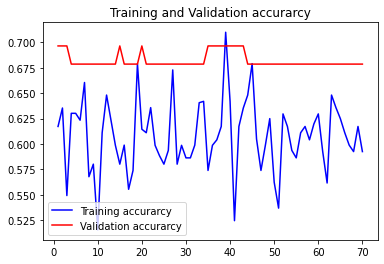

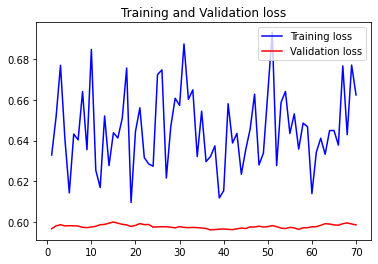

In [49]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

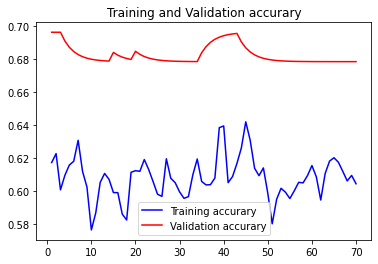

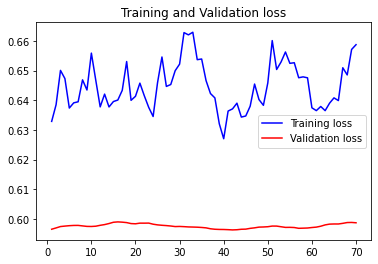

In [50]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurary')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurary')
plt.title('Training and Validation accurary')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [51]:
#Prepare test set

X_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 'adc':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 'adc':
            X_test.append(array)

In [52]:
x = np.array(X_test)
y = np.array(y_test)
total = len(x)
test_datagen = ImageDataGenerator(rescale=1./255)

predictions = 0
correct = 0
false_pos = 0
false_neg = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    prediction = 1 if pred > 0.5 else 0
    actual = 1 if y[i] == 1 else 0
    if prediction == actual:
        correct += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    predictions += prediction
    i += 1
    if i == total:
        break
    
print('ACCURACY: {}%'.format(correct/total * 100))
print('FALSE POSITIVE: {}%'.format(false_pos/(total-correct) * 100))
print('FALSE NEGATIVE: {}%'.format(false_neg/(total-correct) * 100))
print('CLINICALLY SIGNIFICANT PREDICTION: {}%'.format(predictions/total * 100))

ACCURACY: 37.096774193548384%
FALSE POSITIVE: 84.61538461538461%
FALSE NEGATIVE: 15.384615384615385%
CLINICALLY SIGNIFICANT PREDICTION: 66.12903225806451%
